In [34]:
import gzip
import json
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
from tqdm import tqdm

from document_preprocessor import Doc2QueryAugmenter

In [35]:
DRIVE_PATH = '../data/'
CACHE_PATH = '../cache/'
DATASET_PATH = DRIVE_PATH + 'wikipedia_200k_dataset.jsonl.gz'
MAX_DOCS = 100
TEXT_KEY = 'text'

In [36]:
# Load texts
texts = []
if DATASET_PATH.endswith('.jsonl.gz'):
    dataset_file = gzip.open(DATASET_PATH, 'rt')
elif DATASET_PATH.endswith('.jsonl'):
    dataset_file = open(DATASET_PATH, 'r')
else:
    raise ValueError('Unknown file format: %s' % DATASET_PATH)
with jsonlines.Reader(dataset_file) as reader:
    if MAX_DOCS == -1:
        MAX_DOCS = 200000
    for _ in tqdm(range(MAX_DOCS)):
        sample = reader.read()
        texts.append(sample[TEXT_KEY])

100%|██████████| 100/100 [00:00<00:00, 1860.29it/s]


In [37]:
def generate_query(texts, d2q, prefix_prompt):
    queries = []
    time_list = []
    for text in tqdm(texts):
        start_time = time()
        if prefix_prompt is None:
            queries.append(d2q.get_queries(text, n_queries=1))
        else:
            queries.append(d2q.get_queries(text, n_queries=1, prefix_prompt=prefix_prompt))
        time_list.append(time() - start_time)
    return queries, time_list

In [38]:
d2q = Doc2QueryAugmenter()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [39]:
queries_msmarco, time_msmarco = generate_query(texts, d2q, None)

100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


In [40]:
with open(CACHE_PATH + 'queries_msmarco.jsonl', 'w') as f:
    for query in queries_msmarco:
        f.write(json.dumps(query) + '\n')

In [41]:
d2q = Doc2QueryAugmenter('google/flan-t5-small')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [42]:
queries_flan_small, time_flan_small = generate_query(texts, d2q, 'Generate a query for the following text: ')

100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


In [43]:
with open(CACHE_PATH + 'queries_flan_small.jsonl', 'w') as f:
    for query in queries_flan_small:
        f.write(json.dumps(query) + '\n')

In [44]:
d2q = Doc2QueryAugmenter('google/flan-t5-base')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [45]:
queries_flan_base, time_flan_base = generate_query(texts, d2q, 'Generate a query for the following text: ')

100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


In [46]:
with open(CACHE_PATH + 'queries_flan_base.jsonl', 'w') as f:
    for query in queries_flan_base:
        f.write(json.dumps(query) + '\n')

In [47]:
d2q = Doc2QueryAugmenter('google/flan-t5-large')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [48]:
queries_flan_large, time_flan_large = generate_query(texts, d2q, 'Generate a query for the following text: ')

100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


In [49]:
with open(CACHE_PATH + 'queries_flan_large.jsonl', 'w') as f:
    for query in queries_flan_large:
        f.write(json.dumps(query) + '\n')

In [50]:
df = pd.DataFrame({
    'msmarco': time_msmarco,
    'flan_small': time_flan_small,
    'flan_base': time_flan_base,
    'flan_large': time_flan_large
    })

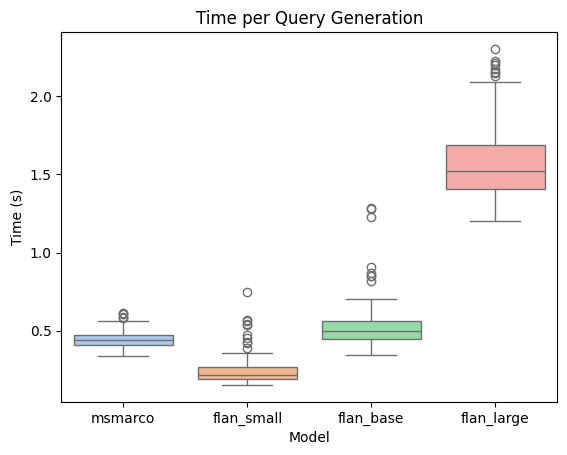

In [51]:
plot = sns.boxplot(data=df, hue_order=['msmarco', 'flan_small', 'flan_base', 'flan_large'], palette="pastel")
plot.set_ylabel('Time (s)')
plot.set_xlabel('Model')
plot.set_title('Time per Query Generation')
plt.show()

In [52]:
print('Average time to generate a query with msmarco: %.2f' % df['msmarco'].mean())
print('Average time to generate a query with flan-small: %.2f' % df['flan_small'].mean())
print('Average time to generate a query with flan-base: %.2f' % df['flan_base'].mean())
print('Average time to generate a query with flan-large: %.2f' % df['flan_large'].mean())

Average time to generate a query with msmarco: 0.45
Average time to generate a query with flan-small: 0.25
Average time to generate a query with flan-base: 0.54
Average time to generate a query with flan-large: 1.58
